In [3]:
import sys
import os
import functools
import scipy
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab
from matplotlib.colors import LogNorm
import pickle
import math
import subprocess
import warnings


sys.path.insert(2, "/global/projecta/projectdirs/lux/data")
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/' )
sys.path.insert(0,'/project/projectdirs/lux/Tools/LUXcode/Trunk/DataAnalysis/Python/aLib' )
import __init__ as S
import dp as dp

pylab.rcParams["figure.figsize"]=15,8

In [4]:
Efieldmap = np.loadtxt("/global/homes/w/weiji/20150208/v0_fields_20140903T1918_cp17059.txt")

In [5]:
def LoadXYZDependentEField(EFieldMap, NumxyzDependentEFieldVars = 8, MinLocationX = -23.50 ,NumPlanesX = 48, StepSizeX = 1. ,MinLocationY = -23.50 ,NumPlanesY = 48, StepSizeY = 1.,MinLocationZ = -33.975 ,NumPlanesZ = 50, StepSizeZ = 1.):
    EFieldMapMatrix = np.zeros((NumPlanesX,NumPlanesY,NumPlanesZ,NumxyzDependentEFieldVars))
    for ii in xrange(0,EFieldMap.shape[0]):
        xx = (int)((EFieldMap[ii,0]-MinLocationX)/StepSizeX)
        yy = (int)((EFieldMap[ii,1]-MinLocationY)/StepSizeY)
        zz = (int)((EFieldMap[ii,2]-MinLocationZ)/StepSizeZ)
        for vv in xrange(0,NumxyzDependentEFieldVars):
            if vv == 2:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv] - MinLocationZ +5.6
            elif vv==6:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            else:
                EFieldMapMatrix[xx,yy,zz,vv] = EFieldMap[ii,vv]
            
                
    return EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))


In [6]:
def GetXYZDependentElectricField_s2(x,LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    try:
        xx=0
        yy=0
        zz=0
        distance2 = 10000
        for xxx in xrange(0,NumPlanesX):
            for yyy in xrange(0,NumPlanesY):  
                 for zzz in xrange(0,NumPlanesZ):
                    if distance2 > ((x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2)+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.:                                               
                        xx = xxx
                        yy = yyy
                        zz = zzz
                        distance2 = (x[0]-EFieldMapMatrix[xxx,yyy,zzz,4])**2+(x[1]-EFieldMapMatrix[xxx,yyy,zzz,5])**2+(x[2]-EFieldMapMatrix[xxx,yyy,zzz,6])**2/144.
        if ifprint:
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print "x,y,z,",EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2]
            print "S2x,S2y,t,",EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6]

            print distance2
        return EFieldMapMatrix[xx,yy,zz,:]
    except :
        return -100000

In [7]:
def errorf(x,*args):
    (S2x,S2y,T),(x0,y0,z0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz) = args
    return (S2x - (s2x0 + (x[0]-x0)*ds2xdx + (x[1]-y0)*ds2xdy + (x[2]-z0)*ds2xdz))**2 \
            +(S2y - (s2y0 + (x[0]-x0)*ds2ydx + (x[1]-y0)*ds2ydy + (x[2]-z0)*ds2ydz))**2 \
            +(T - (t0 + (x[0]-x0)*dtdx + (x[1]-y0)*dtdy + (x[2]-z0)*dtdz))**2 
 

In [8]:
def intepolation(x,x0,f0,dfdx):
    x=np.array(x)
    x0 = np.array(x0)
    dfdx = np.array(dfdx)
    return f0+np.sum(dfdx*(x-x0))

In [9]:
def GetXYZFromXYZS2TDependentElectricField((S2x,S2y,DriftTime),LoadEFieldMap,ifprint=0):
    EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    """
        This function is getting real x y z E from known S2x,S2y,DriftTime,fieldmap
        S2x, S2y in cm
        DriftTime in us
    """
    warnings.filterwarnings('error')
    try:
        xx=25
        yy=25
        zz=25
        attempt=50
        notsuccess = 1
        while((attempt > 0) and notsuccess):
            attempt-=1
            notsuccess = 0
            
            if S2x< EFieldMapMatrix[xx,yy,zz,4]:
                notsuccess = 1
                xx -= 1
            elif S2x > EFieldMapMatrix[xx+1,yy,zz,4]:
                notsuccess = 1
                xx += 1
            if S2y< EFieldMapMatrix[xx,yy,zz,5]:
                notsuccess = 1
                yy -= 1
            elif S2y > EFieldMapMatrix[xx,yy+1,zz,5]:
                notsuccess = 1
                yy += 1
            if DriftTime < EFieldMapMatrix[xx,yy,zz,6]:
                notsuccess = 1
                zz += 1
            elif DriftTime > EFieldMapMatrix[xx,yy,zz+1,6]:
                notsuccess = 1
                zz -= 1
            if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2:
                if ifprint:
                    print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
                return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
            if ifprint:
                print "attempt",attempt
                print "xx,yy,zz",xx,yy,zz
        if ifprint:
            print "xx,yy,zz",xx,yy,zz
        if attempt ==0 and ifprint:
            print "Did not find a point in the map matches with (S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns )"
            print "One of the closest point is (S2x =",EFieldMapMatrix[xx,yy,zz,4],"cm, S2y =",EFieldMapMatrix[xx,yy,zz,5],"cm, DriftTime =",EFieldMapMatrix[xx,yy,zz,6],"ns )"
            print "Check whether you are using the right field map and right S2x, S2y,S2z",attempt
        if xx<0 or xx >NumPlanesX-2 or yy<0 or yy >NumPlanesY-2 or zz<0 or zz >NumPlanesZ-2 or\
            np.isnan(EFieldMapMatrix[xx,yy,zz,3])            :
            if ifprint:
                print "(S2x =",S2x ,"cm, S2y =",S2y ,"cm, DriftTime =",DriftTime,"ns ) is OUT of range in the field map."
            return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
        def dfdx(xx,yy,zz,num):
            dfdx = 1./4./StepSizeX*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]-EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdy = 1./4./StepSizeY*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     +EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]-EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdz = 1./4./StepSizeZ*(-EFieldMapMatrix[xx,yy,zz,num]+EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            return (dfdx,dfdy,dfdz)
        (ds2xdx,ds2xdy,ds2xdz) = dfdx(xx,yy,zz,4)
        (ds2ydx,ds2ydy,ds2ydz) = dfdx(xx,yy,zz,5)
        (dtdx,dtdy,dtdz)   = dfdx(xx,yy,zz,6)
        (xreal0,yreal0,zreal0) = (EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2])
        (s2x0,s2y0,t0) = (EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6])
           
        result= sp.optimize.fmin(errorf,x0=(xreal0,yreal0,zreal0),args = ((S2x,S2y,DriftTime),(xreal0,yreal0,zreal0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz)),disp=0)
        if ifprint:
            print result
        (xreal,yreal,zreal) = result
        E = intepolation((xreal,yreal,zreal),(xreal0,yreal0,zreal0),EFieldMapMatrix[xx,yy,zz,3],dfdx(xx,yy,zz,3))
        
        if ifprint:
            print "index_x,y,z,E",xx,yy,zz,EFieldMapMatrix[xx,yy,zz,3]
            print xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7]

        
    except BaseException:
        return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    #return (np.nan,np.nan,np.nan,np.nan,S2x,S2y,DriftTime,np.nan)
    return (xreal,yreal,zreal,E,S2x,S2y,DriftTime,EFieldMapMatrix[xx,yy,zz,7])

In [10]:
LoadEFieldMap = LoadXYZDependentEField(Efieldmap)

In [11]:
GetXYZDependentElectricField_s2((13,4.3,28),LoadEFieldMap,ifprint=1)

index_x,y,z,E 37 28 43 41032.915
x,y,z, 13.5 4.5 48.6
S2x,S2y,t, 13.182 4.357 28.0
0.036373


array([  1.35000000e+01,   4.50000000e+00,   4.86000000e+01,
         4.10329150e+04,   1.31820000e+01,   4.35700000e+00,
         2.80000000e+01,   1.00000000e+00])

In [12]:
GetXYZFromXYZS2TDependentElectricField((float(-25),float(-25),float(0)),LoadEFieldMap,ifprint=1)

attempt 49
xx,yy,zz 24 24 26
attempt 48
xx,yy,zz 23 23 27
attempt 47
xx,yy,zz 22 22 28
attempt 46
xx,yy,zz 21 21 29
attempt 45
xx,yy,zz 20 20 30
attempt 44
xx,yy,zz 19 19 31
attempt 43
xx,yy,zz 18 18 32
attempt 42
xx,yy,zz 17 17 33
attempt 41
xx,yy,zz 16 16 34
attempt 40
xx,yy,zz 15 15 35
attempt 39
xx,yy,zz 14 14 36
attempt 38
xx,yy,zz 13 13 37
attempt 37
xx,yy,zz 12 12 38
attempt 36
xx,yy,zz 11 11 39
attempt 35
xx,yy,zz 10 10 40
attempt 34
xx,yy,zz 9 9 41
attempt 33
xx,yy,zz 8 8 42
attempt 32
xx,yy,zz 7 7 43
attempt 31
xx,yy,zz 6 6 43
attempt 30
xx,yy,zz 6 6 43
xx,yy,zz 6 6 43
(S2x = -25.0 cm, S2y = -25.0 cm, DriftTime = 0.0 ns ) is OUT of range in the field map.


(nan, nan, nan, nan, -25.0, -25.0, 0.0, nan)

In [13]:
GetXYZFromXYZS2TDependentElectricField((float(-25),float(-25),float(0)),LoadEFieldMap,ifprint=0)

(nan, nan, nan, nan, -25.0, -25.0, 0.0, nan)

In [14]:
        def dfdx(xx,yy,zz,num):
            dfdx = 1./4./StepSizeX*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]-EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdy = 1./4./StepSizeY*(-EFieldMapMatrix[xx,yy,zz,num]-EFieldMapMatrix[xx,yy,zz+1,num]\
                     +EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]-EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     +EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            dfdz = 1./4./StepSizeZ*(-EFieldMapMatrix[xx,yy,zz,num]+EFieldMapMatrix[xx,yy,zz+1,num]\
                     -EFieldMapMatrix[xx,yy+1,zz,num]+EFieldMapMatrix[xx,yy+1,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy,zz,num]+EFieldMapMatrix[xx+1,yy,zz+1,num]\
                     -EFieldMapMatrix[xx+1,yy+1,zz,num]+EFieldMapMatrix[xx+1,yy+1,zz+1,num])
            return (dfdx,dfdy,dfdz)
        def f(x,*args):
            (S2x,S2y,T),(x0,y0,z0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz) = args
            return (S2x - (s2x0 + (x[0]-x0)*ds2xdx + (x[1]-y0)*ds2xdy + (x[2]-z0)*ds2xdz))**2 \
                    +(S2y - (s2y0 + (x[0]-x0)*ds2ydx + (x[1]-y0)*ds2ydy + (x[2]-z0)*ds2ydz))**2 \
                    +(T - (t0 + (x[0]-x0)*dtdx + (x[1]-y0)*dtdy + (x[2]-z0)*dtdz))**2 
  

In [15]:
EFieldMapMatrix,NumxyzDependentEFieldVars,((MinLocationX,NumPlanesX,StepSizeX),(MinLocationY,NumPlanesY,StepSizeY),(MinLocationZ,NumPlanesZ,StepSizeZ))= LoadEFieldMap    
    

In [16]:
EFieldMapMatrix[6,6,43,:]

array([-17.5, -17.5,  48.6,   nan,   nan,   nan,   nan,   0. ])

In [17]:
xx,yy,zz=36,27,44


In [18]:
        (ds2xdx,ds2xdy,ds2xdz) = dfdx(xx,yy,zz,4)
        (ds2ydx,ds2ydy,ds2ydz) = dfdx(xx,yy,zz,5)
        (dtdx,dtdy,dtdz)   = dfdx(xx,yy,zz,6)
        (xreal0,yreal0,zreal0) = (EFieldMapMatrix[xx,yy,zz,0],EFieldMapMatrix[xx,yy,zz,1],EFieldMapMatrix[xx,yy,zz,2])
        (s2x0,s2y0,t0) = (EFieldMapMatrix[xx,yy,zz,4],EFieldMapMatrix[xx,yy,zz,5],EFieldMapMatrix[xx,yy,zz,6])
  

In [19]:
S2x,S2y,DriftTime = 13,4.3,28

In [20]:
args0 =[(S2x,S2y,DriftTime),(xreal0,yreal0,zreal0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz)]

In [21]:
result= sp.optimize.fmin(f,x0=(xreal0,yreal0,zreal0),args = ((S2x,S2y,DriftTime),(xreal0,yreal0,zreal0),(s2x0,s2y0,t0),(ds2xdx,ds2xdy,ds2xdz),(ds2ydx,ds2ydy,ds2ydz),(dtdx,dtdy,dtdz)))


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 94
         Function evaluations: 173


In [22]:
result

array([ 13.28129828,   4.4282311 ,  48.60000392])

In [23]:
np.nan

nan

In [24]:
50*50*75

187500

In [25]:
Efields2map = np.zeros((48*48*50,8))

In [30]:
index=0
for ii in np.linspace(-23.5,23.5,48):
    for jj in np.linspace(-23.5,23.5,48):
        for kk in np.linspace(0,375,50,endpoint=False):
            temp = GetXYZFromXYZS2TDependentElectricField((float(ii),float(jj),float(kk)),LoadEFieldMap,ifprint=0)
            for ll in xrange(0,8,1):
                Efields2map[index,ll]=temp[ll]
            index+=1

In [32]:
np.save("/global/homes/w/weiji/20150208/s2_v0_fields_20140903T1918_cp17059.txt",Efields2map)

ValueError: need more than 1 value to unpack

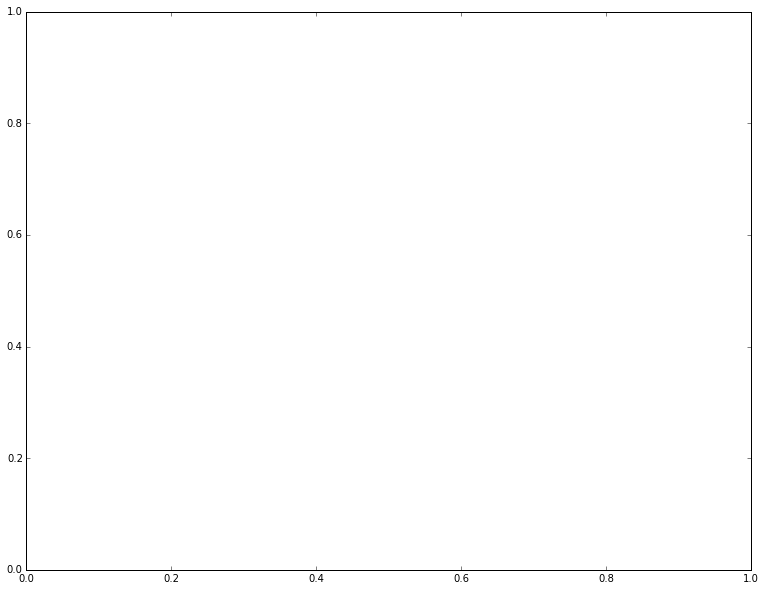

In [35]:
# dritft time vs S2R^2
plt.figure(70,figsize=(13,10))

plt.pcolor((Efields2map[:,0]**2+Efields2map[:,1]**2),Efields2map[:,2]**2,Efields2map[:,3])

cbar = plt.colorbar()
plt.xlabel("r^2 (cm^2)",fontsize=18)
plt.ylabel("-drift_time (samples)",fontsize=18)
plt.title("Tritium Sept 2014", fontsize=20)

In [40]:
plt.pcolor?


In [37]:
Efields2map[:,2]**2


array([    nan,     nan,     nan, ...,  184.96,  184.96,  184.96])

In [38]:
(Efields2map[:,0]**2+Efields2map[:,1]**2)

array([   nan,    nan,    nan, ...,  614.5,  614.5,  614.5])

ValueError: need more than 1 value to unpack

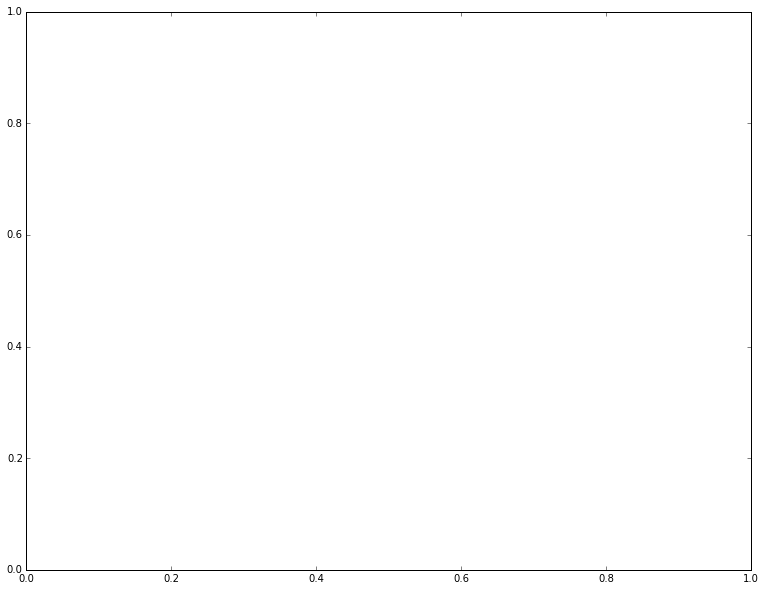

In [45]:
plt.figure(70,figsize=(13,10))
plt.pcolor(Efields2map[:,0],Efields2map[:,2],Efields2map[:,3])